In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, shutil
import torch
import time
import pdb
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True,
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 15
                    }
                   )
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
import head
import numpy as np
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import  qExpectedImprovement
from matplotlib.cm import ScalarMappable
from scipy.spatial import distance
import pdb
from botorch.utils.sampling import draw_sobol_samples
from botorch.optim.optimize import optimize_acqf
from botorch.acquisition import PosteriorMean
from matplotlib import cm
import matplotlib

N_SAMPLES = 100
BATCH_SIZE = 4
N_ITERATIONS = 15
NUM_RESTARTS = 64 
RAW_SAMPLES = 1024
N_INIT_SAMPLES = BATCH_SIZE
NUM_FILTERS = 5

TARGET = [-2,0.5]
VERBOSE = False
savedir = '../figures/notebooks'

INFO: Using numpy backend


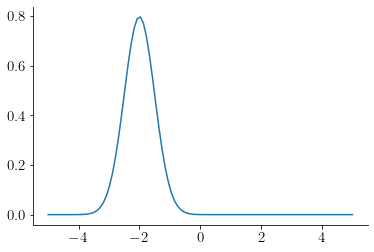

In [3]:
lambda_ = np.linspace(-5,5,num=N_SAMPLES)
def gaussian(mu,sig):
    scale = 1/(np.sqrt(2*np.pi)*sig)
    return scale*np.exp(-np.power(lambda_ - mu, 2.) / (2 * np.power(sig, 2.)))

yt = gaussian(*TARGET)

fig, ax = plt.subplots()
ax.plot(lambda_, yt)
plt.show()

In [4]:
# define search space
param_mu = [-5,5]
param_sig = [0.1,3.5]
bounds = torch.tensor((param_mu, param_sig)).T.to(**tkwargs)

In [5]:
def draw_random_batch(n_samples=6):
    train_x = draw_sobol_samples(
        bounds=bounds,n=1, q=n_samples, 
        seed=torch.randint(2021, (1,)).item()
    ).squeeze(0)
    return train_x

random_x = draw_random_batch(n_samples=N_INIT_SAMPLES)

## Metric selection

In [18]:
from geomstats.geometry.poincare_half_space import PoincareHalfSpace
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.functions import L2Space, SinfSpace
H2 = PoincareHalfSpace(2)
Rn = Euclidean(N_SAMPLES)
R2 = Euclidean(len(TARGET))
L2 = L2Space(lambda_)
Sinf = SinfSpace(lambda_)

metric = 'L2'

if metric=='L2':
    d = lambda xi,yi : -L2.metric.dist(yi, yt)
elif metric=='Rn':
    d = lambda xi,yi : -float(Rn.metric.dist(yi, yt))
elif metric=='H2':
    xt = np.asarray(TARGET).reshape(1,2)
    d = lambda xi,yi : -float(H2.metric.dist(xi.reshape(1,2),xt))
elif metric=='R2':
    xt = np.asarray(TARGET).reshape(1,2)
    d = lambda xi,yi : -float(R2.metric.dist(xi.reshape(1,2),xt))  
elif metric=='Sinf':
    d = lambda xi,yi : -Sinf.metric.dist(yi, yt)
else:
    raise NotImplementedError('Metric %s is not implemented'%metric)

In [19]:
class Oracle:
    def __init__(self, metric):
        self.metric = metric
        self.expt_id = 0
        self.expt = {}
        
    def evaluate(self, x):
        """Scoring function at a given input location
        Uses the simulator sim to generate response spectra at a given locations
        and return a similarity score to target spectra
        """
        x_np = x.cpu().numpy()
        yi = gaussian(x_np[0],x_np[1])
        dist = self.metric(x_np, yi)

        self.expt[self.expt_id] = [lambda_, yi, dist]
    
        return torch.tensor([dist])
    
    def batch_evaluate(self, x):
        print('Current experiment id : ', self.expt_id)
        out = []
        for xi in x.squeeze(1):
            out.append(self.evaluate(xi))
            self.expt_id += 1
        return torch.stack(out, dim=0).to(**tkwargs)
    
oracle = Oracle(d)
print(oracle.__dict__)

{'metric': <function <lambda> at 0x7faad850c5e0>, 'expt_id': 0, 'expt': {}}


In [20]:
def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    model = SingleTaskGP(train_x, train_obj, 
    outcome_transform=Standardize(m=train_obj.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

In [21]:
def selector(f,oracle, q = BATCH_SIZE):
    new_x, _ = optimize_acqf(
        acq_function=f,
        bounds=bounds,
        q=q,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES, 
        sequential=False,
    )
    new_obj = oracle.batch_evaluate(new_x)
    return new_x, new_obj

## Main optimization loop

In [22]:
# Evaluate the randomly selected points
train_x = random_x.clone()
train_obj = oracle.batch_evaluate(train_x)
if VERBOSE:
    print('Generated %d samples randomly'%N_INIT_SAMPLES, train_x.shape, train_obj.shape)
    for i in range(N_INIT_SAMPLES):
        print('%d\t%s\t%s'%(i, train_x[i,...].numpy(), train_obj[i,...].numpy()))
        
mll, model = initialize_model(train_x, train_obj)
# run N_ITERATIONS rounds of BayesOpt after the initial random batch
if VERBOSE:
    print('Sampled ID \t Locations \t Objectives')
for iteration in range(1, N_ITERATIONS + 1): 
    if VERBOSE:
        print('Iteration : %d/%d'%(iteration, N_ITERATIONS))
    # fit the models
    fit_gpytorch_model(mll)

    # define the acquisition module
    #acquisition = qUpperConfidenceBound(model, beta=0.1)
    best_f = train_obj.max(axis=0).values
    acquisition = qExpectedImprovement(model, best_f = best_f)
    
    # optimize acquisition functions and get new observations
    new_x, new_obj = selector(acquisition, oracle)
    if VERBOSE:
        for i in range(BATCH_SIZE):
            print('%d\t%s\t%s'%(i, new_x[i,...].numpy(), 
                                new_obj[i,...].numpy()))

    # update training points
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])
    # re-initialize
    mll, model = initialize_model(train_x, train_obj)
    
expt = oracle.expt

Current experiment id :  0
Current experiment id :  4
Current experiment id :  8
Current experiment id :  12
Current experiment id :  16
Current experiment id :  20
Current experiment id :  24
Current experiment id :  28
Current experiment id :  32
Current experiment id :  36
Current experiment id :  40
Current experiment id :  44
Current experiment id :  48
Current experiment id :  52
Current experiment id :  56
Current experiment id :  60


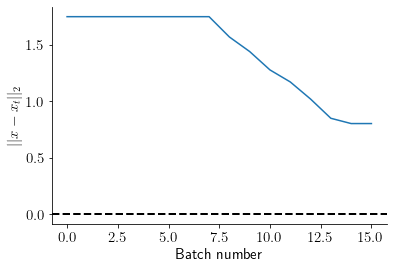

In [23]:
batch_number = torch.cat(
    [torch.zeros(N_INIT_SAMPLES), 
     torch.arange(1, N_ITERATIONS+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]
).numpy()

def plot_best_trace(ax, train_x, train_obj, target):
    train_x = train_x.cpu().numpy()
    proximities = distance.cdist(train_x, np.asarray(TARGET).reshape(1,2))
    trace = np.asarray([min(proximities[batch_number<=b]) for b in np.unique(batch_number)])
    return ax.plot(np.arange(N_ITERATIONS+1),trace)

fig, ax = plt.subplots()
ax.axhline(0, label='Optimal', ls='--', lw='2.0', c='k')
plot_best_trace(ax, train_x, train_obj, TARGET)
ax.set_xlabel('Batch number')
ax.set_ylabel(r'$||x-x_{t}||_{2}$')
plt.show()

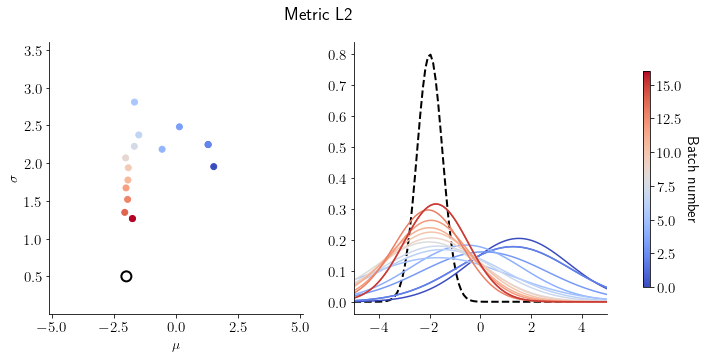

In [24]:
fig, axs = plt.subplots(1,2,figsize=(5*2,5))
batches = np.unique(batch_number)
best_ind = [np.argmax(train_obj.numpy()[batch_number<=b]) for b in batches]
best_loc = train_x[best_ind].numpy()
ax = axs[0]
ax.scatter(best_loc[:,0], best_loc[:,1], c=batches, cmap='coolwarm')
ax.set_xlim(bounds.numpy()[:,0] + np.asarray([-0.1,0.1]))
ax.set_ylim(bounds.numpy()[:,1] + np.asarray([-0.1,0.1]))
ax.scatter(TARGET[0], TARGET[1], marker='o', 
           s=100, facecolors='none', color='k', lw=2.0)
ax.set_xlabel(r'$\mu$', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)

ax = axs[1]
ax.plot(lambda_, yt, 'k--', lw=2.0)
cmap = cm.get_cmap('coolwarm')
norm = matplotlib.colors.Normalize(vmin=0, vmax = len(batches))
for i, bind in enumerate(best_ind):
    wl, ext, _ = expt[bind]
    ax.plot(wl, ext, color=cmap(norm(i)))
ax.set_xlim([-5,5])
cax = plt.axes([0.95, 0.2, 0.01, 0.6])        
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
cbar.ax.set_ylabel('Batch number', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
fig.suptitle('Metric %s'%metric)
plt.savefig(savedir+'/trace_%s.png'%metric, dpi=400, bbox_inches='tight')
plt.show()

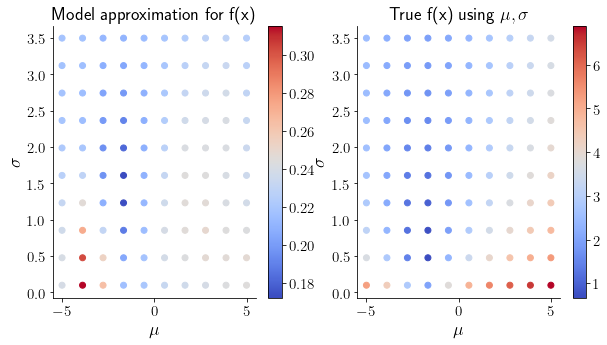

In [25]:
fig, axs = plt.subplots(1,2, figsize=(5*2, 5))
for ax in axs:
    ax.set_xlabel(r'$\mu$', fontsize=18)
    ax.set_ylabel(r'$\sigma$', fontsize=18)
with torch.no_grad():
    mu_grid = np.linspace(*bounds[:,0].numpy(), num=10)
    sig_grid = np.linspace(*bounds[:,1].numpy(), num=10)
    test_x = head.Grid(mu_grid, sig_grid).points
    posterior = model.posterior(torch.tensor(test_x).to(**tkwargs))
    sc = axs[0].scatter(test_x[:,0], test_x[:,1], 
                        c=-posterior.mean.cpu().numpy(), 
                        cmap='coolwarm')
    fig.colorbar(sc, ax=axs[0])
    axs[0].set_title('Model approximation for f(x)')
    
    #sc = axs[1].scatter(test_x[:,0], test_x[:,1], c=distance.cdist(test_x, np.asarray(TARGET).reshape(1,2)))
    sc = axs[1].scatter(test_x[:,0], test_x[:,1], 
                        c=H2.metric.dist(test_x, np.asarray(TARGET).reshape(1,2)),
                        cmap='coolwarm')
    fig.colorbar(sc, ax=axs[1])
    axs[1].set_title(r'True f(x) using $\mu, \sigma$')
plt.show()

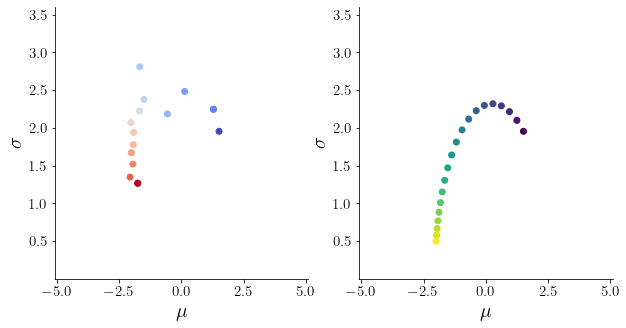

In [26]:
# plot trace in H2
from geomstats import visualization as viz

fig, axs = plt.subplots(1,2, figsize=(5*2, 5))

viz.plot(best_loc,c=batches,cmap='coolwarm', 
              space='H2_poincare_half_plane', ax=axs[0])

xt = np.asarray(TARGET).reshape(1,2)
x0 = best_loc[0,:]
geodesic = H2.metric.geodesic(x0, xt)
n_points = 20
t = np.linspace(0, 1, n_points)
viz.plot(geodesic(t),c=t,space='H2_poincare_half_plane', ax= axs[1])

for ax in axs:
    ax.set_xlabel(r'$\mu$', fontsize=20)
    ax.set_ylabel(r'$\sigma$', fontsize=20)
    ax.set_xlim(bounds.numpy()[:,0] + np.asarray([-0.1,0.1]))
    ax.set_ylim(bounds.numpy()[:,1] + np.asarray([-0.1,0.1]))
    
plt.savefig(savedir+'/geodesic_compare_%s.png'%metric, dpi=400, bbox_inches='tight')
plt.show()

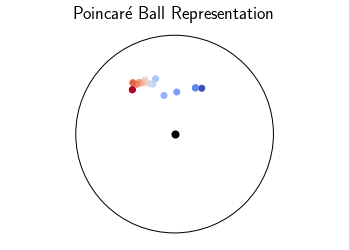

In [27]:
def to_ball(points):
    denom = points[:,0]**2 + (1+points[:,1])**2
    proj_x = 2*points[:,0]/denom
    proj_y = (points[:,0]**2+points[:,1]**2-1)/denom
    fig, ax = plt.subplots()
    circle = plt.Circle((0, 0), radius=1.0, color="black", fill=False)
    ax.scatter(proj_x, proj_y, c=batches, cmap='coolwarm')
    ax.scatter(0,0, color='k', s=50)
    ax.add_patch(circle)
    ax.axis('equal')
    ax.axis('off')
    ax.set_title('Poincaré Ball Representation')
    plt.show()
    
to_ball(best_loc)